# AI6126 ACV Project 1


In [1]:
nb_ver = 0.5
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = "randerase"
print(comments)

ai6126-project1-colab-v0.5
randerase


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

## Setup/ Configuration

### Colab

In [2]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [3]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import os
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne

In [6]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

if 'ipykernel' in sys.modules:
    config.disable_tqdm = False
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation and testing

def load_dataloaders(print_info=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing()
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ]),
        'test': transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [10]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrResNet']


In [11]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    model = model.to(device)
    return model
#print(model)

### Criterion & Optimizer

In [12]:
# criterion = nn.CrossEntropyLoss().to(device)

# optimizer = torch.optim.SGD(model.parameters(), config.lr,
#                             momentum=config.momentum,
#                             weight_decay=config.weight_decay)

### Resume Checkpoint if any

In [13]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1 = model.load_ckp(optimizer, ckp_resume)
        # print(f"=> loading checkpoint '{config.resume}'")
        # checkpoint = torch.load(config.resume)
        # start_epoch = checkpoint['epoch']
        # best_prec1 = checkpoint['best_prec1']
        # model.load_state_dict(checkpoint['state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer'])
        # print(f"=> loaded checkpoint '{config.resume}' (epoch {start_epoch})")
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, start_epoch, logger

## Train & Validate Function

In [14]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)):
            loss.append(criterion(output[j], y[:, j]))
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [15]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(val_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()  
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [16]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))

    for epoch in range(start_epoch, config.epochs):
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict()
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)

In [17]:
def get_run_name_time(model, criterion, optimizer, comments):
    if str(criterion) == 'CrossEntropyLoss()':
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

=> creating model 'FaceAttrResNet'
Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
=> resuming model: checkpoints\checkpoint.pth.tar
=> loading checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\checkpoint.pth.tar' (epoch 40)
FaceAttrResNet18_42_s40e60_tb256_vb128_CE_SGD_randerase_step_lr0.1_wd0.0001_g0.1_sp30 20201002_081735

Epoch: [41 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:37<12:47,  1.43s/it]

(100/636) Data: 0.371s | Batch: 0.971s | Total: 0:01:37 | ETA: 0:07:35 | Loss: 0.1719 | top1:  92.3968


 31%|█████████████████████████▏                                                      | 200/636 [03:10<05:40,  1.28it/s]

(200/636) Data: 0.369s | Batch: 0.953s | Total: 0:03:10 | ETA: 0:06:04 | Loss: 0.1724 | top1:  92.3748


 47%|█████████████████████████████████████▋                                          | 300/636 [04:41<06:40,  1.19s/it]

(300/636) Data: 0.358s | Batch: 0.938s | Total: 0:04:41 | ETA: 0:04:32 | Loss: 0.1727 | top1:  92.3644


 63%|██████████████████████████████████████████████████▎                             | 400/636 [06:11<02:54,  1.35it/s]

(400/636) Data: 0.352s | Batch: 0.929s | Total: 0:06:11 | ETA: 0:03:05 | Loss: 0.1729 | top1:  92.3569


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [07:39<02:31,  1.11s/it]

(500/636) Data: 0.343s | Batch: 0.919s | Total: 0:07:39 | ETA: 0:01:48 | Loss: 0.1730 | top1:  92.3540


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [09:27<00:41,  1.14s/it]

(600/636) Data: 0.376s | Batch: 0.945s | Total: 0:09:27 | ETA: 0:00:46 | Loss: 0.1730 | top1:  92.3574


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [42 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.095s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1738 | top1:  92.3222


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:30,  1.61it/s]

(200/636) Data: 0.048s | Batch: 0.666s | Total: 0:02:13 | ETA: 0:04:32 | Loss: 0.1732 | top1:  92.3624


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:29,  1.61it/s]

(300/636) Data: 0.033s | Batch: 0.651s | Total: 0:03:15 | ETA: 0:03:30 | Loss: 0.1732 | top1:  92.3572


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:17<02:26,  1.61it/s]

(400/636) Data: 0.025s | Batch: 0.644s | Total: 0:04:17 | ETA: 0:02:28 | Loss: 0.1729 | top1:  92.3669


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:19<01:24,  1.61it/s]

(500/636) Data: 0.020s | Batch: 0.640s | Total: 0:05:19 | ETA: 0:01:26 | Loss: 0.1729 | top1:  92.3651


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:21<00:22,  1.61it/s]

(600/636) Data: 0.017s | Batch: 0.637s | Total: 0:06:21 | ETA: 0:00:24 | Loss: 0.1730 | top1:  92.3663


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.26it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [43 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:33,  1.61it/s]

(100/636) Data: 0.090s | Batch: 0.707s | Total: 0:01:10 | ETA: 0:05:34 | Loss: 0.1729 | top1:  92.3729


 31%|█████████████████████████▏                                                      | 200/636 [02:12<04:30,  1.61it/s]

(200/636) Data: 0.046s | Batch: 0.664s | Total: 0:02:12 | ETA: 0:04:32 | Loss: 0.1731 | top1:  92.3756


 47%|█████████████████████████████████████▋                                          | 300/636 [03:14<03:28,  1.61it/s]

(300/636) Data: 0.031s | Batch: 0.650s | Total: 0:03:14 | ETA: 0:03:30 | Loss: 0.1731 | top1:  92.3715


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:17<02:26,  1.61it/s]

(400/636) Data: 0.024s | Batch: 0.643s | Total: 0:04:17 | ETA: 0:02:28 | Loss: 0.1730 | top1:  92.3708


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:19<01:24,  1.61it/s]

(500/636) Data: 0.019s | Batch: 0.638s | Total: 0:05:19 | ETA: 0:01:26 | Loss: 0.1728 | top1:  92.3793


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:21<00:22,  1.61it/s]

(600/636) Data: 0.016s | Batch: 0.636s | Total: 0:06:21 | ETA: 0:00:24 | Loss: 0.1729 | top1:  92.3686


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.25it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [44 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:10<05:33,  1.61it/s]

(100/636) Data: 0.089s | Batch: 0.706s | Total: 0:01:10 | ETA: 0:05:34 | Loss: 0.1730 | top1:  92.3552


 31%|█████████████████████████▏                                                      | 200/636 [02:12<04:31,  1.61it/s]

(200/636) Data: 0.045s | Batch: 0.664s | Total: 0:02:12 | ETA: 0:04:32 | Loss: 0.1733 | top1:  92.3463


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:32,  1.58it/s]

(300/636) Data: 0.031s | Batch: 0.652s | Total: 0:03:15 | ETA: 0:03:33 | Loss: 0.1730 | top1:  92.3474


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.60it/s]

(400/636) Data: 0.023s | Batch: 0.646s | Total: 0:04:18 | ETA: 0:02:29 | Loss: 0.1731 | top1:  92.3480


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:22<01:28,  1.53it/s]

(500/636) Data: 0.019s | Batch: 0.645s | Total: 0:05:22 | ETA: 0:01:31 | Loss: 0.1729 | top1:  92.3637


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:26<00:22,  1.59it/s]

(600/636) Data: 0.016s | Batch: 0.645s | Total: 0:06:26 | ETA: 0:00:24 | Loss: 0.1730 | top1:  92.3610


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [45 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:13<05:34,  1.60it/s]

(100/636) Data: 0.103s | Batch: 0.733s | Total: 0:01:13 | ETA: 0:05:35 | Loss: 0.1736 | top1:  92.3335


 31%|█████████████████████████▏                                                      | 200/636 [02:15<04:30,  1.61it/s]

(200/636) Data: 0.052s | Batch: 0.677s | Total: 0:02:15 | ETA: 0:04:32 | Loss: 0.1731 | top1:  92.3595


 47%|█████████████████████████████████████▋                                          | 300/636 [03:18<03:31,  1.59it/s]

(300/636) Data: 0.036s | Batch: 0.663s | Total: 0:03:18 | ETA: 0:03:35 | Loss: 0.1730 | top1:  92.3608


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:22<02:27,  1.60it/s]

(400/636) Data: 0.027s | Batch: 0.655s | Total: 0:04:22 | ETA: 0:02:28 | Loss: 0.1729 | top1:  92.3688


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:25<01:25,  1.60it/s]

(500/636) Data: 0.022s | Batch: 0.650s | Total: 0:05:25 | ETA: 0:01:26 | Loss: 0.1729 | top1:  92.3645


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:27<00:22,  1.60it/s]

(600/636) Data: 0.019s | Batch: 0.646s | Total: 0:06:27 | ETA: 0:00:24 | Loss: 0.1730 | top1:  92.3643


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.23it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [46 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:32,  1.61it/s]

(100/636) Data: 0.092s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1728 | top1:  92.3644


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:31,  1.60it/s]

(200/636) Data: 0.047s | Batch: 0.666s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1731 | top1:  92.3435


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:28,  1.61it/s]

(300/636) Data: 0.032s | Batch: 0.652s | Total: 0:03:15 | ETA: 0:03:31 | Loss: 0.1732 | top1:  92.3415


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:17<02:26,  1.61it/s]

(400/636) Data: 0.024s | Batch: 0.645s | Total: 0:04:17 | ETA: 0:02:28 | Loss: 0.1730 | top1:  92.3499


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.61it/s]

(500/636) Data: 0.020s | Batch: 0.640s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1728 | top1:  92.3576


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:22<00:22,  1.61it/s]

(600/636) Data: 0.017s | Batch: 0.637s | Total: 0:06:22 | ETA: 0:00:24 | Loss: 0.1727 | top1:  92.3603


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.90it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [47 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:50,  1.53it/s]

(100/636) Data: 0.096s | Batch: 0.725s | Total: 0:01:12 | ETA: 0:05:44 | Loss: 0.1727 | top1:  92.3638


 31%|█████████████████████████▏                                                      | 200/636 [02:15<04:31,  1.60it/s]

(200/636) Data: 0.049s | Batch: 0.678s | Total: 0:02:15 | ETA: 0:04:34 | Loss: 0.1727 | top1:  92.3708


 47%|█████████████████████████████████████▋                                          | 300/636 [03:19<03:38,  1.54it/s]

(300/636) Data: 0.033s | Batch: 0.666s | Total: 0:03:19 | ETA: 0:03:39 | Loss: 0.1726 | top1:  92.3716


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:22<02:30,  1.57it/s]

(400/636) Data: 0.025s | Batch: 0.657s | Total: 0:04:22 | ETA: 0:02:30 | Loss: 0.1727 | top1:  92.3676


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:26<01:26,  1.57it/s]

(500/636) Data: 0.020s | Batch: 0.652s | Total: 0:05:26 | ETA: 0:01:29 | Loss: 0.1728 | top1:  92.3654


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:29<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.649s | Total: 0:06:29 | ETA: 0:00:24 | Loss: 0.1728 | top1:  92.3675


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.22it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [48 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:32,  1.61it/s]

(100/636) Data: 0.094s | Batch: 0.710s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1729 | top1:  92.3760


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:31,  1.61it/s]

(200/636) Data: 0.048s | Batch: 0.666s | Total: 0:02:13 | ETA: 0:04:32 | Loss: 0.1728 | top1:  92.3766


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:28,  1.61it/s]

(300/636) Data: 0.032s | Batch: 0.651s | Total: 0:03:15 | ETA: 0:03:30 | Loss: 0.1730 | top1:  92.3714


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:17<02:26,  1.61it/s]

(400/636) Data: 0.025s | Batch: 0.644s | Total: 0:04:17 | ETA: 0:02:28 | Loss: 0.1729 | top1:  92.3820


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:19<01:24,  1.61it/s]

(500/636) Data: 0.020s | Batch: 0.639s | Total: 0:05:19 | ETA: 0:01:26 | Loss: 0.1729 | top1:  92.3786


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:21<00:22,  1.61it/s]

(600/636) Data: 0.017s | Batch: 0.636s | Total: 0:06:21 | ETA: 0:00:24 | Loss: 0.1729 | top1:  92.3736


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.31it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [49 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:32,  1.61it/s]

(100/636) Data: 0.093s | Batch: 0.710s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1716 | top1:  92.4338


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:30,  1.61it/s]

(200/636) Data: 0.047s | Batch: 0.666s | Total: 0:02:13 | ETA: 0:04:32 | Loss: 0.1725 | top1:  92.3938


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:28,  1.61it/s]

(300/636) Data: 0.032s | Batch: 0.651s | Total: 0:03:15 | ETA: 0:03:30 | Loss: 0.1725 | top1:  92.3917


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:43,  1.44it/s]

(400/636) Data: 0.024s | Batch: 0.646s | Total: 0:04:18 | ETA: 0:02:38 | Loss: 0.1725 | top1:  92.3856


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:22<01:29,  1.52it/s]

(500/636) Data: 0.020s | Batch: 0.645s | Total: 0:05:22 | ETA: 0:01:30 | Loss: 0.1726 | top1:  92.3802


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:26<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.643s | Total: 0:06:26 | ETA: 0:00:24 | Loss: 0.1727 | top1:  92.3783


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.67it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [50 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:33,  1.61it/s]

(100/636) Data: 0.101s | Batch: 0.728s | Total: 0:01:12 | ETA: 0:05:34 | Loss: 0.1729 | top1:  92.3446


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:47,  1.52it/s]

(200/636) Data: 0.052s | Batch: 0.682s | Total: 0:02:16 | ETA: 0:04:52 | Loss: 0.1730 | top1:  92.3465


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:36,  1.55it/s]

(300/636) Data: 0.035s | Batch: 0.668s | Total: 0:03:20 | ETA: 0:03:38 | Loss: 0.1733 | top1:  92.3440


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:28,  1.59it/s]

(400/636) Data: 0.027s | Batch: 0.660s | Total: 0:04:24 | ETA: 0:02:30 | Loss: 0.1730 | top1:  92.3578


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:28,  1.54it/s]

(500/636) Data: 0.022s | Batch: 0.658s | Total: 0:05:29 | ETA: 0:01:32 | Loss: 0.1729 | top1:  92.3609


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:23,  1.54it/s]

(600/636) Data: 0.018s | Batch: 0.657s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 0.1728 | top1:  92.3670


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.79it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [51 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:32,  1.61it/s]

(100/636) Data: 0.101s | Batch: 0.722s | Total: 0:01:12 | ETA: 0:05:35 | Loss: 0.1729 | top1:  92.3706


 31%|█████████████████████████▏                                                      | 200/636 [02:14<04:30,  1.61it/s]

(200/636) Data: 0.051s | Batch: 0.671s | Total: 0:02:14 | ETA: 0:04:31 | Loss: 0.1725 | top1:  92.3923


 47%|█████████████████████████████████████▋                                          | 300/636 [03:19<03:48,  1.47it/s]

(300/636) Data: 0.035s | Batch: 0.664s | Total: 0:03:19 | ETA: 0:03:47 | Loss: 0.1727 | top1:  92.3841


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:23<02:30,  1.56it/s]

(400/636) Data: 0.027s | Batch: 0.658s | Total: 0:04:23 | ETA: 0:02:30 | Loss: 0.1726 | top1:  92.3809


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:28,  1.54it/s]

(500/636) Data: 0.022s | Batch: 0.655s | Total: 0:05:27 | ETA: 0:01:26 | Loss: 0.1727 | top1:  92.3794


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:33<00:24,  1.48it/s]

(600/636) Data: 0.018s | Batch: 0.656s | Total: 0:06:33 | ETA: 0:00:25 | Loss: 0.1727 | top1:  92.3777


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.21it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [52 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:12<05:52,  1.52it/s]

(100/636) Data: 0.094s | Batch: 0.724s | Total: 0:01:12 | ETA: 0:05:40 | Loss: 0.1730 | top1:  92.3593


 31%|█████████████████████████▏                                                      | 200/636 [02:16<04:34,  1.59it/s]

(200/636) Data: 0.048s | Batch: 0.680s | Total: 0:02:16 | ETA: 0:04:38 | Loss: 0.1725 | top1:  92.3737


 47%|█████████████████████████████████████▋                                          | 300/636 [03:20<03:36,  1.55it/s]

(300/636) Data: 0.033s | Batch: 0.669s | Total: 0:03:20 | ETA: 0:03:37 | Loss: 0.1727 | top1:  92.3582


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:24<02:27,  1.60it/s]

(400/636) Data: 0.025s | Batch: 0.661s | Total: 0:04:24 | ETA: 0:02:28 | Loss: 0.1726 | top1:  92.3674


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:27<01:24,  1.60it/s]

(500/636) Data: 0.020s | Batch: 0.655s | Total: 0:05:27 | ETA: 0:01:26 | Loss: 0.1726 | top1:  92.3709


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:29<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.650s | Total: 0:06:29 | ETA: 0:00:24 | Loss: 0.1726 | top1:  92.3667


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.05it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [53 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.096s | Batch: 0.713s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1720 | top1:  92.4075


 31%|█████████████████████████▏                                                      | 200/636 [02:14<04:46,  1.52it/s]

(200/636) Data: 0.049s | Batch: 0.671s | Total: 0:02:14 | ETA: 0:04:41 | Loss: 0.1723 | top1:  92.4003


 47%|█████████████████████████████████████▋                                          | 300/636 [03:17<03:32,  1.58it/s]

(300/636) Data: 0.033s | Batch: 0.659s | Total: 0:03:17 | ETA: 0:03:34 | Loss: 0.1727 | top1:  92.3803


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:21<02:32,  1.55it/s]

(400/636) Data: 0.025s | Batch: 0.655s | Total: 0:04:21 | ETA: 0:02:34 | Loss: 0.1727 | top1:  92.3797


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:25<01:25,  1.59it/s]

(500/636) Data: 0.021s | Batch: 0.651s | Total: 0:05:25 | ETA: 0:01:27 | Loss: 0.1727 | top1:  92.3767


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:29<00:22,  1.58it/s]

(600/636) Data: 0.017s | Batch: 0.650s | Total: 0:06:29 | ETA: 0:00:24 | Loss: 0.1728 | top1:  92.3681


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.77it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [54 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:14<05:34,  1.60it/s]

(100/636) Data: 0.096s | Batch: 0.742s | Total: 0:01:14 | ETA: 0:05:36 | Loss: 0.1731 | top1:  92.3766


 31%|█████████████████████████▏                                                      | 200/636 [02:18<04:36,  1.58it/s]

(200/636) Data: 0.049s | Batch: 0.693s | Total: 0:02:18 | ETA: 0:04:36 | Loss: 0.1728 | top1:  92.3812


 47%|█████████████████████████████████████▋                                          | 300/636 [03:22<03:36,  1.55it/s]

(300/636) Data: 0.033s | Batch: 0.674s | Total: 0:03:22 | ETA: 0:03:37 | Loss: 0.1729 | top1:  92.3721


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:25<02:29,  1.58it/s]

(400/636) Data: 0.025s | Batch: 0.664s | Total: 0:04:25 | ETA: 0:02:30 | Loss: 0.1728 | top1:  92.3715


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:29<01:27,  1.55it/s]

(500/636) Data: 0.021s | Batch: 0.659s | Total: 0:05:29 | ETA: 0:01:29 | Loss: 0.1728 | top1:  92.3713


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:34<00:22,  1.59it/s]

(600/636) Data: 0.018s | Batch: 0.658s | Total: 0:06:34 | ETA: 0:00:24 | Loss: 0.1728 | top1:  92.3695


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.54it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [55 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.094s | Batch: 0.714s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1727 | top1:  92.3691


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:31,  1.60it/s]

(200/636) Data: 0.048s | Batch: 0.668s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1727 | top1:  92.3707


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:29,  1.61it/s]

(300/636) Data: 0.032s | Batch: 0.653s | Total: 0:03:15 | ETA: 0:03:30 | Loss: 0.1724 | top1:  92.3932


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.60it/s]

(400/636) Data: 0.025s | Batch: 0.646s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1727 | top1:  92.3750


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.60it/s]

(500/636) Data: 0.020s | Batch: 0.641s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1726 | top1:  92.3769


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:22<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.638s | Total: 0:06:22 | ETA: 0:00:24 | Loss: 0.1727 | top1:  92.3667


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.09it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [56 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.095s | Batch: 0.713s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1725 | top1:  92.3760


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:31,  1.60it/s]

(200/636) Data: 0.048s | Batch: 0.668s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1722 | top1:  92.3925


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:29,  1.61it/s]

(300/636) Data: 0.033s | Batch: 0.653s | Total: 0:03:15 | ETA: 0:03:31 | Loss: 0.1725 | top1:  92.3790


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:26,  1.61it/s]

(400/636) Data: 0.025s | Batch: 0.645s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1726 | top1:  92.3742


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.60it/s]

(500/636) Data: 0.020s | Batch: 0.641s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1726 | top1:  92.3770


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:23<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.639s | Total: 0:06:23 | ETA: 0:00:24 | Loss: 0.1726 | top1:  92.3770


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.10it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [57 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.093s | Batch: 0.711s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1728 | top1:  92.3905


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:32,  1.60it/s]

(200/636) Data: 0.047s | Batch: 0.667s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1727 | top1:  92.3791


 47%|█████████████████████████████████████▋                                          | 300/636 [03:15<03:29,  1.60it/s]

(300/636) Data: 0.032s | Batch: 0.652s | Total: 0:03:15 | ETA: 0:03:31 | Loss: 0.1726 | top1:  92.3778


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.60it/s]

(400/636) Data: 0.024s | Batch: 0.645s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1725 | top1:  92.3842


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.60it/s]

(500/636) Data: 0.020s | Batch: 0.641s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1723 | top1:  92.3935


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:22<00:22,  1.61it/s]

(600/636) Data: 0.017s | Batch: 0.638s | Total: 0:06:22 | ETA: 0:00:24 | Loss: 0.1723 | top1:  92.3887


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [58 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:34,  1.60it/s]

(100/636) Data: 0.097s | Batch: 0.716s | Total: 0:01:11 | ETA: 0:05:35 | Loss: 0.1722 | top1:  92.3879


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:32,  1.60it/s]

(200/636) Data: 0.049s | Batch: 0.670s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1720 | top1:  92.3949


 47%|█████████████████████████████████████▋                                          | 300/636 [03:16<03:29,  1.60it/s]

(300/636) Data: 0.033s | Batch: 0.654s | Total: 0:03:16 | ETA: 0:03:31 | Loss: 0.1722 | top1:  92.3806


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.61it/s]

(400/636) Data: 0.025s | Batch: 0.647s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1722 | top1:  92.3906


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.61it/s]

(500/636) Data: 0.021s | Batch: 0.642s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1723 | top1:  92.3841


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:23<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.639s | Total: 0:06:23 | ETA: 0:00:24 | Loss: 0.1724 | top1:  92.3820


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.08it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [59 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.098s | Batch: 0.716s | Total: 0:01:11 | ETA: 0:05:34 | Loss: 0.1727 | top1:  92.3841


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:32,  1.60it/s]

(200/636) Data: 0.050s | Batch: 0.669s | Total: 0:02:13 | ETA: 0:04:34 | Loss: 0.1724 | top1:  92.3840


 47%|█████████████████████████████████████▋                                          | 300/636 [03:16<03:30,  1.60it/s]

(300/636) Data: 0.034s | Batch: 0.654s | Total: 0:03:16 | ETA: 0:03:30 | Loss: 0.1722 | top1:  92.4052


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.60it/s]

(400/636) Data: 0.026s | Batch: 0.646s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1721 | top1:  92.3980


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.61it/s]

(500/636) Data: 0.021s | Batch: 0.642s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1723 | top1:  92.3923


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:23<00:22,  1.60it/s]

(600/636) Data: 0.018s | Batch: 0.639s | Total: 0:06:23 | ETA: 0:00:24 | Loss: 0.1723 | top1:  92.3920


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.10it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [60 | 60] LR: 0.000000


 16%|████████████▌                                                                   | 100/636 [01:11<05:33,  1.61it/s]

(100/636) Data: 0.095s | Batch: 0.714s | Total: 0:01:11 | ETA: 0:05:35 | Loss: 0.1731 | top1:  92.3729


 31%|█████████████████████████▏                                                      | 200/636 [02:13<04:32,  1.60it/s]

(200/636) Data: 0.048s | Batch: 0.668s | Total: 0:02:13 | ETA: 0:04:33 | Loss: 0.1726 | top1:  92.3820


 47%|█████████████████████████████████████▋                                          | 300/636 [03:16<03:30,  1.60it/s]

(300/636) Data: 0.033s | Batch: 0.653s | Total: 0:03:16 | ETA: 0:03:31 | Loss: 0.1726 | top1:  92.3706


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:18<02:27,  1.60it/s]

(400/636) Data: 0.025s | Batch: 0.646s | Total: 0:04:18 | ETA: 0:02:28 | Loss: 0.1726 | top1:  92.3740


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:20<01:24,  1.61it/s]

(500/636) Data: 0.020s | Batch: 0.641s | Total: 0:05:20 | ETA: 0:01:26 | Loss: 0.1724 | top1:  92.3803


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [06:23<00:22,  1.60it/s]

(600/636) Data: 0.017s | Batch: 0.638s | Total: 0:06:23 | ETA: 0:00:24 | Loss: 0.1723 | top1:  92.3836


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.06it/s]


=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Best accuracy:
91.92127648685421
total time taken: 02:29:16


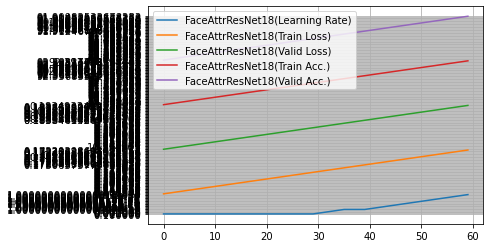

In [18]:
# config.epoch = 1
start_time = time.time()
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = nn.CrossEntropyLoss().to(device)
# print(criterion)
optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
# print(optimizer)
if config.evaluate:
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name)
end_time = time.time()
time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print(f"total time taken: {time_taken}")

In [19]:
# reset_gpu_cache(model,optimizer,criterion, device)

In [20]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = nn.CrossEntropyLoss().to(device)
    best_prec1, _, _ = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname config.checkpoint_fname

    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 40)


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.72it/s]

=> Best test accuracy: 91.51750824898376, Model val acc: 91.92127648685421
5_o_Clock_Shadow: 94.7249774411164
Arched_Eyebrows: 83.90441839112844
Attractive: 82.83238153254122
Bags_Under_Eyes: 85.31209294149362
Bald: 99.02314397354975
Bangs: 96.09257586285891
Big_Lips: 72.49273617508153
Big_Nose: 84.54062715344458
Black_Hair: 90.09618273728262
Blond_Hair: 96.11261393825393
Blurry: 96.19276622148855
Brown_Hair: 89.47500249787952
Bushy_Eyebrows: 92.87646525575718
Chubby: 95.79701430505436
Double_Chin: 96.43322308953785
Eyeglasses: 99.66937180643222
Goatee: 97.60545032739329
Gray_Hair: 98.31179236811539
Heavy_Makeup: 91.71926660273049
High_Cheekbones: 87.9971946752235
Male: 98.4019637372042
Mouth_Slightly_Open: 93.84831176718065
Mustache: 96.97425108316152
Narrow_Eyes: 87.59643322541712
No_Beard: 96.15269007681367
Oval_Face: 76.59553150222483
Pale_Skin: 97.19466987887337
Pointy_Nose: 77.46718763667326
Receding_Hairline: 93.7831880473718
Rosy_Cheeks: 95.29606248438806
Sideburns: 97.89600237

In [21]:
# Wait for notebook to save
%autosave 1
time.sleep(150)
%autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [22]:
def backup_everything(run_time, run_name, title):
    # backup checkpoints
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    # backup notebook html
    nb_name = title + '.ipynb'
    html_name = title + '.html'
    save_name = os.path.join(run_dir, html_name)
    !jupyter nbconvert --to html $nb_name
    !move $html_name $save_name
    
backup_everything(run_time, run_name, title)

[NbConvertApp] Converting notebook ai6126-project1-colab-v0.5.ipynb to html
[NbConvertApp] Writing 843564 bytes to ai6126-project1-colab-v0.5.html


        1 file(s) moved.


In [ ]:
if config.auto_hibernate and True:
    os.system('shutdown -h')